In [1]:
import pandas as pd
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from typing import List, Callable
from scipy import stats
import timeit
import copy

In [2]:
register_matplotlib_converters()
sns.set()

▶ All graphs should have a legend, a title, labeled x-axis and y-axis with units if applicable.  
▶ Don’t plot log of (physical) quantities. Please use log scales instead.  
Don’t leave plot randomly in the notebook without context. Please indicate question
numbers and comment on your results if necessary (especially if they are not what you
were expecting).  

Do not use seaborn.



TODO: adapt the legend with plt.legend, or put proper names during the computations.  
explain the graphs like in an article.

# Simulation of homogeneous Poisson Processes.

In [3]:
def plot_poisson_process(T_i: List[float]) -> None:
    eps = .1
    t = np.linspace(0, T_i[-1] + eps, num = int(T_i[-1] * 30))
    aux_fun = lambda s: np.sum([s > jump_time for jump_time in T_i])
    N_t = [aux_fun(t_k) for t_k in t]
    fig, ax = plt.subplots()
    ax.plot(t, 
             N_t)
    ax.set_title('Plot of the counting process N_t.')
    ax.set_ylabel('number of jumps')
    ax.set_xlabel('time')
    ax.xaxis.set_tick_params(rotation=45)
    ax.grid(True)
    ax.legend()

In [4]:
def plot_fn(x_i: List[float], y_i: List[List[float]], title: str, xlabel: str, ylabel: str) -> None:
    fig, ax = plt.subplots()
    for courbe in y_i:
        ax.plot(x_i, 
                courbe)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.xaxis.set_tick_params(rotation=45)
    ax.grid(True)
    ax.legend()

In [5]:
class HawkesProcess:
    def __init__(self, baseline_intensity, kernel, T):
        self.kernel = kernel
        self.baseline_intensity = baseline_intensity
        self.T = T
        self.lbd_star = baseline_intensity
    
    def rec_lbd(self, T_i, t):
        if len(T_i) == 0:
            return self.baseline_intensity
        else:
            return self.kernel(t-T_i[-1]) + self.rec_lbd(T_i[:-1], t)
    
    def simulate(self):
        # initialize the  
        self.x_ = [0.] # total abscisse
        self.y_ = [self.baseline_intensity] # stochastic lbd
        self.y_star_ = [self.baseline_intensity] # lbd_star

        # first date of event.
        t_0 = 0
        T_i = [t_0]

        while t_0 <= self.T:
            # new candidate.
            s = stats.expon.rvs(scale = 1 / self.lbd_star)
            print('s ', s)
            t_0 += s
            print('new t_0 ', t_0)

            if t_0 > self.T:
                return T_i
            
            # thinning.
            d = stats.uniform.rvs()
            print('ratio ', self.rec_lbd(T_i, t_0) / self.lbd_star)
            print('lambda_star ', self.lbd_star)
            print('t_0', t_0)
            print('lbd_t_0- ', self.rec_lbd(T_i, t_0-0.01))
            print('lbd_t_0 ', self.rec_lbd(T_i, t_0))
            print('lbd_t_0+ ', self.rec_lbd(T_i, t_0+0.01))

            if d < self.rec_lbd(T_i, t_0) / self.lbd_star: # accept the event.

                print('event')
                x = list(np.linspace(t_0 - s, t_0, num = 20))
                y = [self.rec_lbd(T_i, e) for e in x]
                y_star = [self.lbd_star for _ in x]
                print('mean y', np.mean(y))
                self.x_ = self.x_ + copy.deepcopy(x)
                self.y_ = self.y_ + copy.deepcopy(y)
                self.y_star_ = self.y_star_ + copy.deepcopy(y_star)

                # change the T_i, and as a consequence the lbd_fun
                T_i.append(t_0)

                
                print('jump ', self.rec_lbd(T_i, t_0) - self.rec_lbd(T_i, t_0 - 0.01))
                self.lbd_star = self.rec_lbd(T_i, t_0)
                print('new lbd_star ', self.lbd_star)
                print('t_0', t_0)
                print('self.rec_lbd_t0', self.rec_lbd(T_i, t_0))

                

            else: # no event. update lbd_star.
                print('no event')
                self.lbd_star = self.rec_lbd(T_i, t_0)
                print()
            
            print('\n'*3)


        return T_i
            



# 2\ Sanity check 

For this Hawkes process to be sub-critical (stable), one needs alpha / beta < 1 if one chooses an exponential kernel of the form tau: alpha * exp(-beta * tau). Here the selected values are

````
alpha = 3.
beta = 4.
````

In [6]:
alpha = .6
beta = .8

In [7]:
hawkes_process = HawkesProcess(1., lambda tau: alpha * np.exp(-beta * tau), 20.)
process_realization = hawkes_process.simulate()


s  0.3291455964484518
new t_0  0.3291455964484518
ratio  1.4610991879320179
lambda_star  1.0
t_0 0.3291455964484518
lbd_t_0-  1.4648027760354387
lbd_t_0  1.4610991879320179
lbd_t_0+  1.4574251103340132
event
mean y 1.5276654445225684
jump  -0.008522839405984861
new lbd_star  2.061099187932018
t_0 0.3291455964484518
self.rec_lbd_t0 2.061099187932018




s  1.0854739294626552
new t_0  1.414619525911107
ratio  0.701213358273959
lambda_star  2.061099187932018
t_0 1.414619525911107
lbd_t_0-  1.4488467322935628
lbd_t_0  1.4452702833055402
lbd_t_0+  1.4417223317676358
no event





s  0.248428834463513
new t_0  1.66304836037462
ratio  0.9444703880613912
lambda_star  1.4452702833055402
t_0 1.66304836037462
lbd_t_0-  1.3679468168996691
lbd_t_0  1.3650149853271802
lbd_t_0+  1.362106514838344
event
mean y 1.4038842397352227
jump  -0.007751082875052884
new lbd_star  1.9650149853271803
t_0 1.66304836037462
self.rec_lbd_t0 1.9650149853271803




s  0.5193068637449658
new t_0  2.182355224119586
ratio

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


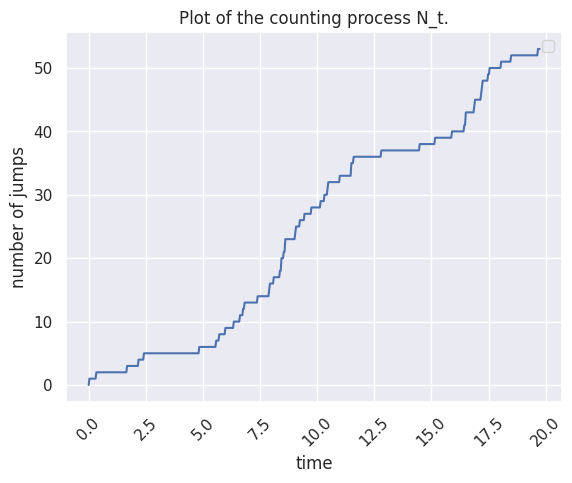

In [8]:
plot_poisson_process(process_realization)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


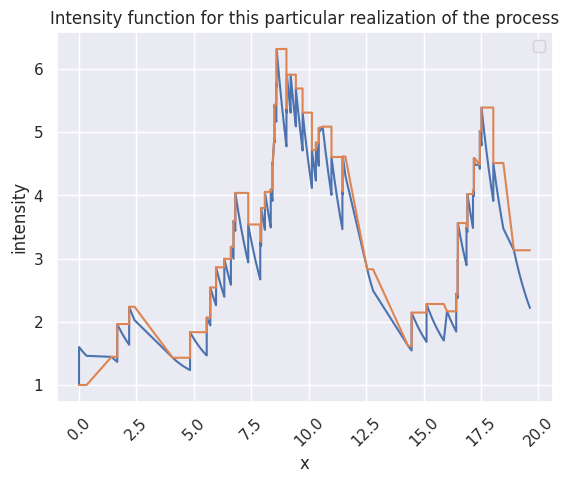

In [9]:
plot_fn(hawkes_process.x_, [hawkes_process.y_, hawkes_process.y_star_ ], 'Intensity function for this particular realization of the process', 'x', 'intensity')